## 1.2. MEG BASICS
**Purpose**: Download/load MEG data, inspect metadata, plot MEG signals, compute Power Spectral Density (PSD), and analyze **Evoked Responses** (ERFs) with topographic layouts.


In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from mne.datasets import sample

# Setup plotting backend for the notebook
%matplotlib inline
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib', set_env=True)

Using matplotlib as 2D backend.


### 1. Downloading the MEG Sample Dataset

The MNE "Sample" dataset is a multi-modal recording (MEG + EEG) from a single participant performing an audio-visual task. We will download it directly to our local `datasets` folder.

- Source: MNE Python provides this dataset as a small, publicly available MEG/EEG dataset for tutorial and testing purposes.
- Acquisition system: Elekta Neuromag MEG system.
- Subject: One healthy adult participant.
- Stimuli: Auditory and visual events. 
  - Task: Passive perception (participant fixates, does not respond).
  - Purpose: Evoked response analysis (auditory ERFs, visual ERFs), topographic mapping, source localization, connectivity, etc.

In [2]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "meg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

print(f"Checking for MEG data in: {target_dir}")

Checking for MEG data in: /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample


In [3]:
data_path = sample.data_path(path=str(target_dir), download=True)
meg_file = Path(data_path) / "MEG" / "sample" / "sample_audvis_raw.fif"

print(f"File ready: {meg_file}")

File ready: /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif


### 2. Loading MEG Data

Unlike EEG, MEG data is typically stored in `.fif` (Functional Imaging File) format. MEG sensors consist of Magnetometers (measuring magnetic field strength) and Gradiometers (measuring the spatial gradient of the magnetic field).

The raw object contains:
- Continuous MEG signals from all sensors (magnetometers + gradiometers)
- Auxiliary channels (e.g., EEG, EOG, stim)
- Sampling frequency and measurement info
- Event markers for stimuli or triggers

In [13]:
raw = mne.io.read_raw_fif(meg_file, preload=True)

print("\n--- Metadata Summary ---")
print(f"Sampling Rate: {raw.info['sfreq']} Hz")
print(f"Total Channels: {len(raw.ch_names)}")

# Filter channel types to see what we have
meg_channels = mne.pick_types(raw.info, meg=True)
print(f"Number of MEG channels: {len(meg_channels)}")

Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...

--- Metadata Summary ---
Sampling Rate: 600.614990234375 Hz
Total Channels: 376
Number of MEG channels: 305


### 3. Understanding MEG Sensor Types
MEG systems usually use two types of sensors:

1. <b>Magnetometers</b>: Highly sensitive to deep sources but also to distant environmental noise.
2. <b>Gradiometers</b>: Measure the difference in magnetic field between two nearby points, making them more sensitive to local cortical activity.

In [5]:
# Inspect the info object to see channel types (mag vs grad)
raw.info

<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

### 4. Visualizing MEG Signals

Because Magnetometers and Gradiometers have different units (Tesla vs Tesla/meter), MNE uses 'scalings' to display them together.
Each line shows a channel’s signal over time. Useful for checking data quality and observing artifacts.

You can inspect:
- Signal amplitudes and noise levels
- Artifacts like heartbeats or eye blinks
- Differences between magnetometers and gradiometers


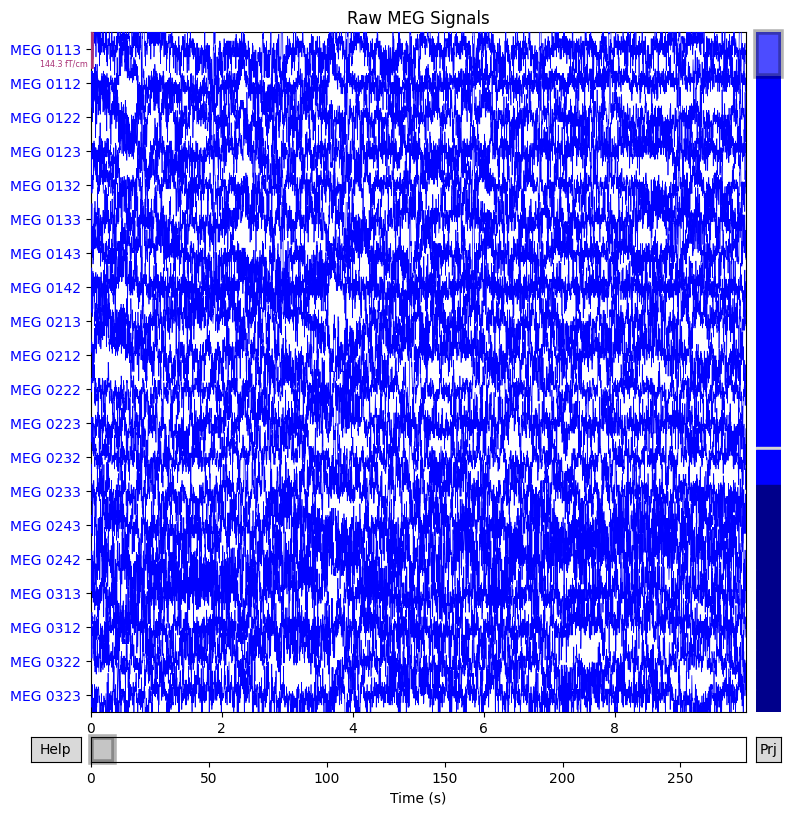

In [14]:
# Plot 10 seconds of data
fig = raw.plot(
    picks="meg",
    n_channels=20, 
    duration=10.0, 
    scalings='auto', 
    show=False
)

ax = fig.axes[0] 
ax.set_title("Raw MEG Signals")

plt.show()

### 5. Frequency Analysis (PSD)

We look at the frequency content of the magnetic fields. MEG is particularly susceptible to power line noise (60Hz in the US, 50Hz in Europe), which appears as sharp spikes in the PSD.

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


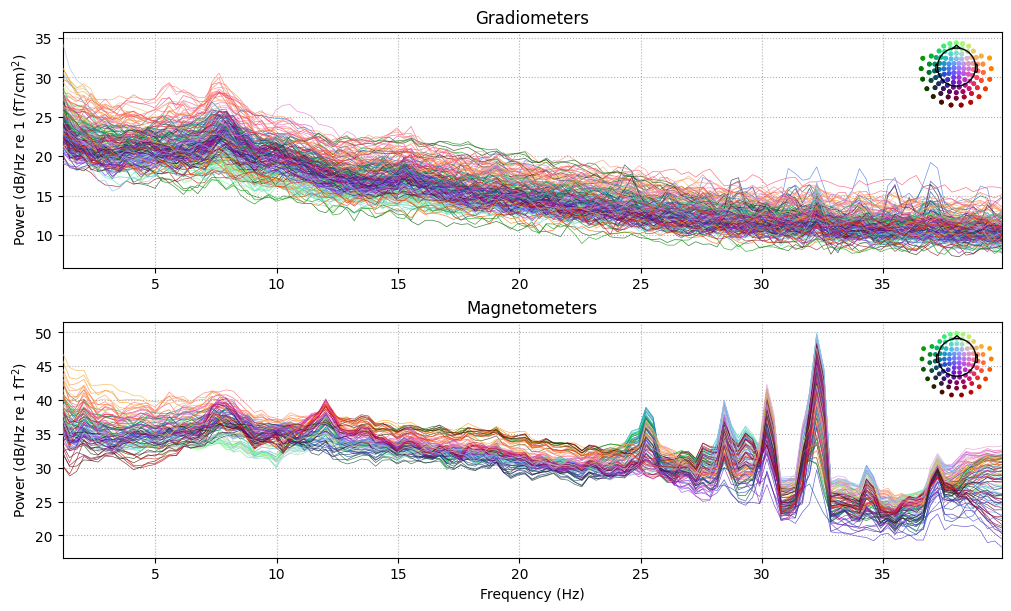

In [15]:
# Compute and plot PSD
psd = raw.compute_psd(fmin=1, fmax=40, picks="meg")

# spatial_colors=True colors the lines based on sensor location on the head
psd.plot(exclude="bads", 
         spatial_colors=True
         )

plt.show()

### 6. Computing Evoked Responses (ERFs)

To see how the brain responds to a stimulus, we:

1. **Find Events**: Extract the timing of stimuli from the 'STI 014' channel.
2. **Epoching**: Cut the continuous data into short segments (epochs) around those events.
3. **Averaging**: Average the epochs to create an **Evoked** object (Magnetic Field Response).

In [ ]:
# 1. Extract events from the stim channel (raw object)
events = mne.find_events(raw, stim_channel='STI 014')

# 2. Define event ID
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}
tmin, tmax = -0.2, 0.5  # 200ms before stimulus to 500ms after

# 3. Create Epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=(None, 0), preload=True)

# 4. Average epochs to get the Evoked response
evoked_dict = {cond: epochs[cond].average() for cond in event_id}

Finding events on: STI 014
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
145 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 145 events and 421 original time points ...
0 bad epochs dropped


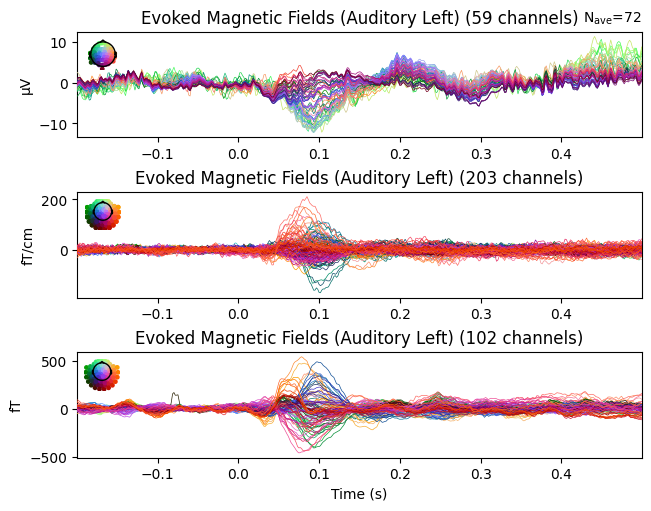

In [17]:
evoked_dict['Auditory/Left'].plot(titles="Evoked Magnetic Fields (Auditory Left)")
plt.show()

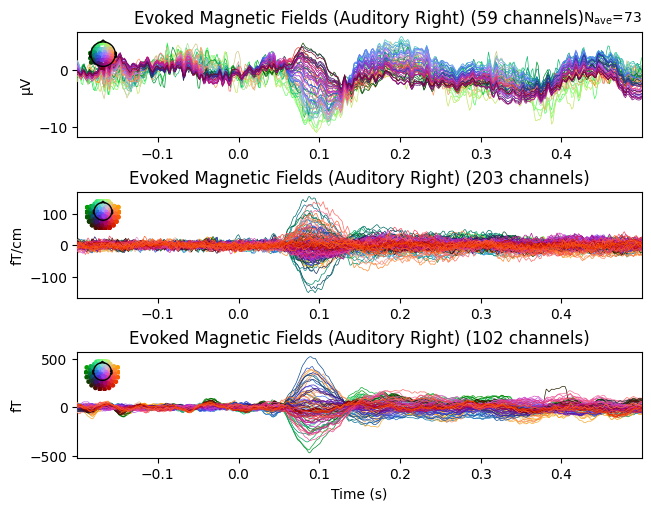

In [18]:
evoked_dict['Auditory/Right'].plot(titles="Evoked Magnetic Fields (Auditory Right)")
plt.show()

### 7. Topographic Layouts

MEG sensors are arranged in a "helmet" shape. A topographic map (topomap) projects the sensor data onto a 2D representation of the head.
- Each sensor’s amplitude is represented as a color on a 2D head plot.
- Red areas indicate positive deflections (higher amplitude) at that time point.
- Blue areas indicate negative deflections (lower amplitude).
- White/neutral regions are near zero.
- By plotting multiple time points (e.g., 100ms, 200ms, 300ms), we can visualize how the neural response **propagates across the scalp** over time.
- These maps are derived from **averaged (Evoked) responses**, which reduces noise and highlights stimulus-locked activity.

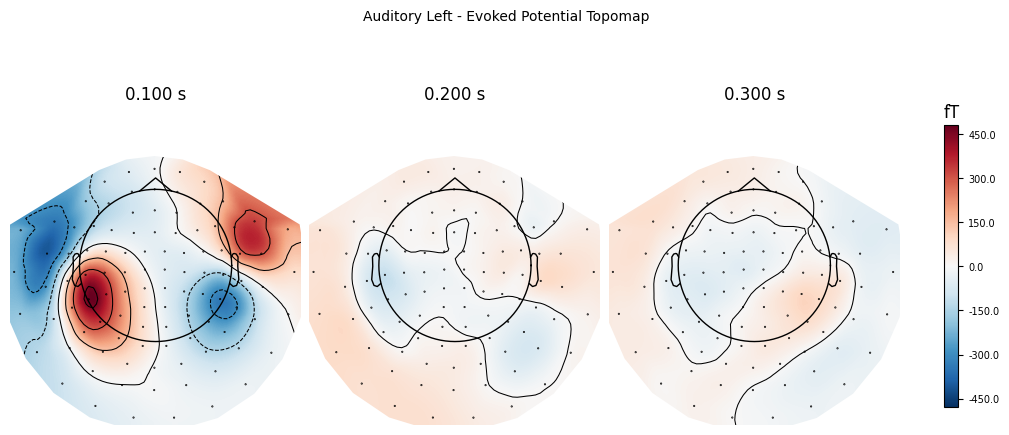

In [19]:
# Example: Auditory Left
fig = evoked_dict['Auditory/Left'].plot_topomap(
    times=[0.1, 0.2, 0.3],
    ch_type='mag',
    show=False,
    time_unit='s',
    size=3.0,
    colorbar=True,
)

plt.suptitle("Auditory Left - Evoked Potential Topomap", fontsize=10)
plt.gcf().set_size_inches((10, 5))
plt.show()

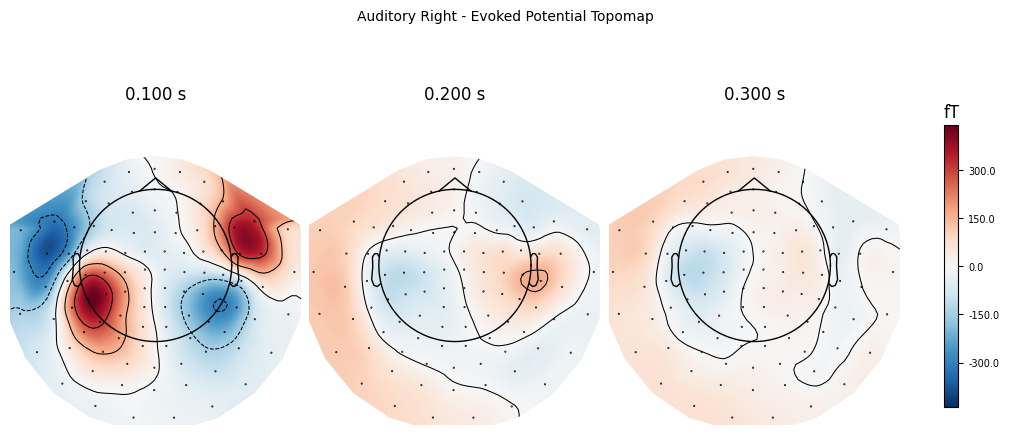

In [20]:
# Example: Auditory Right
fig = evoked_dict['Auditory/Right'].plot_topomap(
    times=[0.1, 0.2, 0.3],
    ch_type='mag',
    show=False,
    time_unit='s',
    size=3.0,
    colorbar=True,
)

plt.suptitle("Auditory Right - Evoked Potential Topomap", fontsize=10)
plt.gcf().set_size_inches((10, 5))
plt.show()